# This file is a practical example and test of approaches to change the population attributable fraction (PAF) for risk factors in Vivarium such that they account for observed correlation in exposure between risks.

This file will investigate the approach that Vivarium currently uses to calculate the PAF for multiple risk factors, which we will call the *multiplicative* approach. In comparison, Abie and Chris and proposing a *joint* approach. 

The first part of the file looks at how we will jointly estimate exposure probabilities from copulae. The second part of the file proposes our alternative formulation of a *joint* PAF. The last part of the file tests our assumptions in a very simple step by step model. 

In [1]:
#import numpy as np, matplotlib.pyplot as plt, pandas as pd
#pd.set_option('display.max_rows', 8)
#!date

#%load_ext autoreload
#%autoreload 2

In [2]:
import numpy as np
import matplotlib as matplot
import pandas as pd

In [3]:
import seaborn as sns
import scipy.stats

# Gaussian copula to correlation two risk factor exposures

And then some investigation of how much error this introduces in the PAF.

This part of our file shows how we can introduce correlation from a multivariate normal distribution. All we need is correlation (variance/covariance) in our exposures.

In [4]:
# Simulate for testing purposes

N = 10_000  # number of individuals

# set random seed for reproducibility
np.random.seed(12345)

# simulate data (to be replaced with real data, e.g. from NHANES, eventually)
df = pd.DataFrame(index=range(N))
df['SBP'] = np.random.normal(130, 20, size=N)
df['LDL-C'] = np.random.normal(4+(df.SBP-130)/20, 1, size=N)  # intentionally include correlation between SBP and LDL-C
df

,SBP,LDL-C
0,125.905847,5.723323
1,139.578867,3.322323
2,119.611226,3.089911
3,118.885394,3.845074
4,169.315611,5.091290
...,...,...
9995,112.742931,3.499870
9996,173.045882,8.809667
9997,129.865889,5.465636
9998,105.705538,3.818431


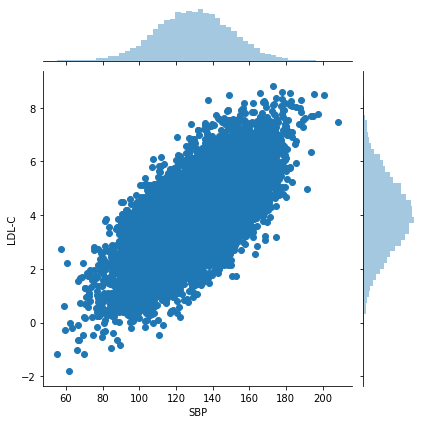

In [5]:
sns.jointplot(df['SBP'], df['LDL-C'])

# What we want from the microdata is simply the Spearman R value, which captures the correlation of SBP and LDL-C as continuous variables

In [6]:
rho, p_val = scipy.stats.spearmanr(df['SBP'], df['LDL-C'])
rho

0.6942625526106255

# What will we use that for?

We will generate a multivariate normal with that rho, and then use that to generate a distribution that is marginally uniform, but with that rho, and then use that to generate a distribution that in its margins matches the SPB and LDL-C from GBD, but also has Spearman correlation rho:

0.6797538355495384

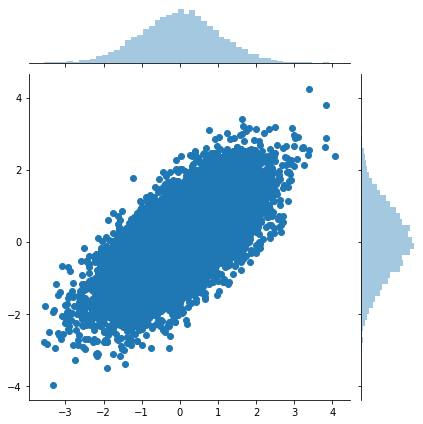

In [7]:
probit_propensity = np.random.multivariate_normal([0,0], [[1, rho],
                                                         [rho, 1]], size=N)
sns.jointplot(probit_propensity[:,0], probit_propensity[:,1])
rho, p_val = scipy.stats.spearmanr(probit_propensity[:,0], probit_propensity[:,1])
rho

0.6797538355495384

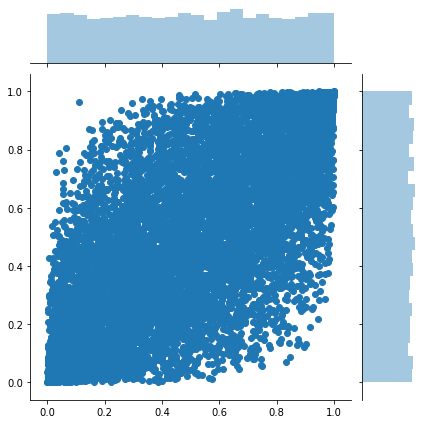

In [8]:
propensity = scipy.stats.norm().cdf(probit_propensity)
sns.jointplot(propensity[:,0], propensity[:,1])
rho, p_val = scipy.stats.spearmanr(propensity[:,0], propensity[:,1])
rho

In [9]:
# HACK: instead of loading marginals from GBD, I'm going to re-use the ones
# I synthesized above

exposure1_vals = df['SBP'].sort_values().values
exposure2_vals = df['LDL-C'].sort_values().values

def exposure1_from_propensity(p):
    p = np.array(p)
    i = np.array(np.floor(p*len(exposure1_vals)), dtype=int)
    return exposure1_vals[i]

def exposure2_from_propensity(p):
    p = np.array(p)
    i = np.array(np.floor(p*len(exposure2_vals)), dtype=int)
    return exposure2_vals[i]


In [10]:
# now map from propensity to value
df_synthetic = pd.DataFrame(index=range(N))
df_synthetic['SBP'] = exposure1_from_propensity(propensity[:,0])
df_synthetic['LDL-C'] = exposure2_from_propensity(propensity[:,1])
df_synthetic

,SBP,LDL-C
0,134.011378,5.192848
1,116.002529,3.155872
2,120.862054,1.630903
3,110.848538,2.214022
4,133.763781,4.926610
...,...,...
9995,135.609528,5.082792
9996,91.988864,3.282778
9997,90.701909,1.307473
9998,122.352818,4.338779


0.6797565466113832

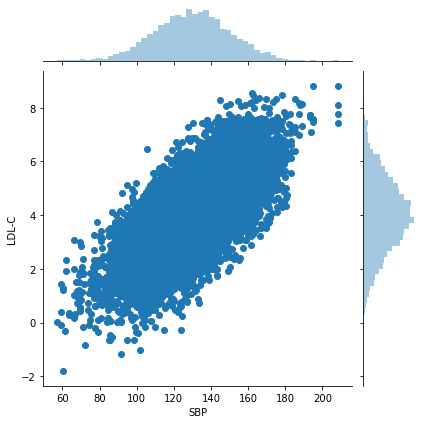

In [11]:
sns.jointplot(df_synthetic['SBP'], df_synthetic['LDL-C'])
rho, p_val = scipy.stats.spearmanr(df_synthetic['SBP'], df_synthetic['LDL-C'])
rho

# The anticipated problem with this approach: how does correlation affect the joint PAF?

This is not relevant to the material above---using the Gaussian Copula to capture the correlation between risk-factor exposure will be fine.  The problem is when we then layer at RiskEffect component into our model, to make the risk have a effect on the incidence or mortality rate of our cause model.  Without loss of generality, suppose the risk effect will change the incidence of first MI.

We have traditionally handled this by calculating a risk-deleted incidence:
$$
i_0 = \left(1-\text{PAF}\right) \cdot i_{\text{GBD}}
$$

If we _just_ include one risk effect, I think we're still ok, even with correlation.  But if we have two risk effects, we have previously used assumption
$$
1 - \text{PAF}_{\text{joint}} = \left(1 - \text{PAF}_{\text{SBP}}\right)\cdot\left(1 - \text{PAF}_{\text{LDL-C}}\right).
$$

The more correlated the risk exposure, the more wrong this assumption.

I propose we continue to assume that the relative risks have a "log linear" relationship with incidence:
$$
i_{e_1, e_2} = i_0 \cdot \left(\text{RR}_1\right)^{e_1}\cdot \left(\text{RR}_2\right)^{e_2},
$$
where I have written $e_1$ and $e_2$ as "standardized" exposures, after scaling and shifting so that the TMREL is 0.0 and a one unit increment gives the relative increase in disease burden reported by GBD.


With the log-linear assumption, we can calculate the PAF from first principles as a double integral (below $p_{e_1,e_2}$ denotes the joint probability density of exposure level $(e_1,e_2)$ in the population:

\begin{align*}
i_{\text{GBD}} &= \int_{e_1} \int_{e_2} i_{e_1, e_2} p_{e_1,e_2} de_1 de_2\\
&= \int_{e_1} \int_{e_2} i_0 \cdot \left(\text{RR}_1\right)^{e_1}\cdot \left(\text{RR}_2\right)^{e_2}
p_{e_1,e_2} de_1 de_2\\
&= \int_{e_1} \int_{e_2} \left(1-\text{PAF}\right) \cdot i_{\text{GBD}} \cdot \left(\text{RR}_1\right)^{e_1}\cdot \left(\text{RR}_2\right)^{e_2}
p_{e_1,e_2} de_1 de_2\\
\end{align*}

Dividing through and cancelling terms yields a solution:
$$
\frac{1}{1-\text{PAF}} = \int_{e_1} \int_{e_2} \left(\text{RR}_1\right)^{e_1}\cdot \left(\text{RR}_2\right)^{e_2}
p_{e_1,e_2} de_1 de_2,
$$

In [12]:
# there are lots of ways to approximate this integral, but here is a cool one:
rr_1 = 1.5
rr_2 = 3

e1 = np.clip((df['SBP'] - 120)/10, 0, np.inf)  # rescale exposures 
e2 = np.clip((df['LDL-C'] - 4), 0, np.inf)

one_over_one_minus_paf = np.mean(rr_1**e1 * rr_2**e2)
paf = 1 - 1/(one_over_one_minus_paf)
paf

0.936944660107624

In [13]:
# how does this compare to multiplicative approx of paf?
ooomp_1 = np.mean(rr_1**e1)
paf_1 = 1 - 1/ooomp_1

ooomp_2 = np.mean(rr_2**e2)
paf_2 = 1 - 1/ooomp_2

1 - (1 - paf_1) * (1 - paf_2)

0.8708098034918508

These values are somewhat different, reflecting the impact of the correlation in SBP and LDL-C in our simulated data. If we used the *multiplicative* PAF, our estimated rate would be quite different. Let's look at a simpler model of categorical risks.

# Chris is adding an example of categorial risk exposures

In [14]:
# simulate categorical data (to be replaced with real data, e.g. from MALED/Surveys, eventually)
df = pd.DataFrame(index=range(N))
# Uncorrelated, binomial 
df['bin_a'] = np.random.binomial(1, 0.3, size=N)
df['bin_b'] = np.random.binomial(1, 0.1, size=N)  

rr_1 = 2.5
rr_2 = 5



Define what I will call a joint PAF:

$$
PAF_{joint} = 1 - \frac{1}{RR_1^{e_1} \cdot RR_2^{e_2}}
$$
   
And also what I will call a multiplicative PAF:

$$
PAF_{multiplicative} = 1 - (1 - \frac{1}{RR_1^{e_1}}) \cdot (1 - \frac{1}{RR_2^{e_2}})
$$

In [15]:
one_over_one_minus_paf = np.mean(rr_1**df['bin_a'] * rr_2**df['bin_b'])
paf = 1 - 1/(one_over_one_minus_paf)
paf

0.5127418018808165

In [16]:
# how does this compare to multiplicative approx of paf?
ooomp_1 = np.mean(rr_1**df['bin_a'])
paf_1 = 1 - 1/ooomp_1

ooomp_2 = np.mean(rr_2**df['bin_b'])
paf_2 = 1 - 1/ooomp_2

1 - (1 - paf_1) * (1 - paf_2)

0.5145153501895934

The approaches give nearly the same estimate of the combined PAF when the exposures are independent.

## Now I am making it a bit more complicated, sim some data for continuous exposures

I have made two pairs of random distributions with the same means and standard deviations. First, I sim without correlation (nml_a, nml_b). Next, I sim with some correlation (cor_a, cor_b). I have continuous distributions at this point so I create four new variables that are binary if they are below -2. The variables "exp_na" and "exp_nb" are for the normal uncorrelated distributions while "exp_ca" and "exp_cb" are for the correlated distributions. This is just intended as an exercise based on the height-for-age z-score definitions of stunting (stunted is <= -2 SD). 

In [17]:
# Uncorrelated, continuous normal
mean_a = 0
sd_a = 1.3

mean_b = -0.5
sd_b = 1

rho = 0.8

df['nml_a'] = np.random.normal(mean_a, sd_a, size=N)
df['nml_b'] = np.random.normal(mean_b, sd_b, size=N)

# Correlated continuous normal
cor_nml = np.random.multivariate_normal([mean_a,mean_b], [[sd_a**2, rho],[rho, sd_b**2]], size=N)
#cor_nml
df['cor_a'] = cor_nml[:,0]
df['cor_b'] = cor_nml[:,1]

# For this example, I am thinking about HAZ, so I will set 'exposed' to less than -2

## Does this work how I am expecting it to in Python?!
df['exp_na'] = 0
df['exp_nb'] = 0
df['exp_ca'] = 0
df['exp_cb'] = 0
for i in range(0,N):
    if (df['nml_a'][i] < (-2)):
        df['exp_na'][i] = 1
for i in range(0,N):
    if(df['nml_b'][i] < (-2)):
        df['exp_nb'][i] = 1
    if(df['cor_a'][i] < (-2)):
        df['exp_ca'][i] = 1
    if(df['cor_b'][i] < (-2)):
        df['exp_cb'][i] = 1
df


C:\Users\ctroeger\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ctroeger\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ctroeger\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ctroege

,bin_a,bin_b,nml_a,nml_b,cor_a,cor_b,exp_na,exp_nb,exp_ca,exp_cb
0,0,1,-0.057584,-0.950021,-1.818019,-0.826437,0,0,0,0
1,1,0,0.382862,0.206593,0.126023,-1.564974,0,0,0,0
2,0,0,0.287244,-0.582161,1.631291,-0.496486,0,0,0,0
3,0,0,-2.595732,-0.208823,0.671197,0.529351,1,0,0,0
4,0,0,-0.603832,-0.572606,0.681999,-0.739108,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,0,0,1.413890,0.426929,-0.502449,-1.987269,0,0,0,0
9996,0,0,0.182369,-0.633904,0.503280,-1.297071,0,0,0,0
9997,0,0,-0.937989,-0.543358,0.014530,-1.185948,0,0,0,0
9998,0,1,1.806999,0.142196,-0.099585,-0.248132,0,0,0,0


In [18]:
# Does this do what I expected it to?
print(np.mean(df['exp_na']), np.mean(df['exp_nb']),
      np.mean(df['exp_ca']), np.mean(df['exp_cb']))

0.0573 0.069 0.0611 0.0721


Text(0.5, 0.98, 'Uncorrelated exposures')

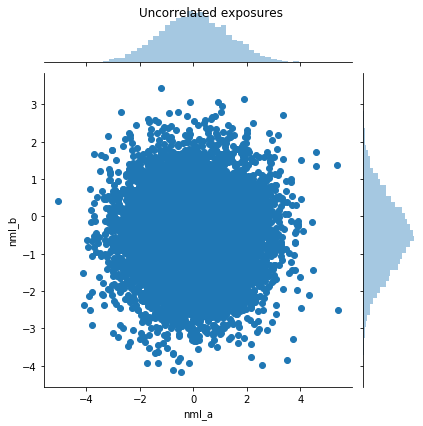

In [36]:
# Compare just to make sure I got what I expected
sns.jointplot(df['nml_a'], df['nml_b'])


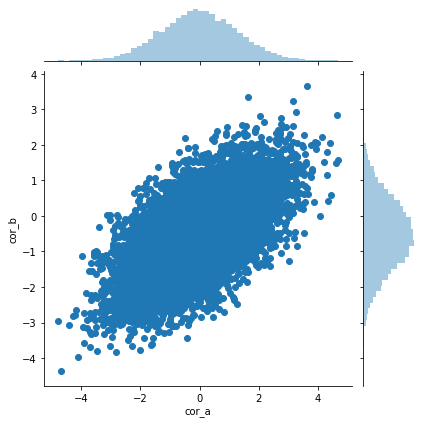

In [20]:
sns.jointplot(df['cor_a'], df['cor_b'])

## When the exposures are independent, it seems that the PAFs from the multiplicative and joint risk approaches are similar.

In [21]:
# What is the value of the joint risk approach?
one_over_one_minus_paf = np.mean(rr_1**df['exp_na'] * rr_2**df['exp_nb'])
paf_j_ind = 1 - 1/(one_over_one_minus_paf)
paf_j_ind

0.2772216399840989

In [22]:
# how does this compare to multiplicative approx of paf?
ooomp_1 = np.mean(rr_1**df['exp_na'])
paf_1 = 1 - 1/ooomp_1

ooomp_2 = np.mean(rr_2**df['exp_nb'])
paf_2 = 1 - 1/ooomp_2

paf_m_ind = 1 - (1 - paf_1) * (1 - paf_2)
paf_m_ind

0.2783285974850329

## However, when the exposures are correlated, it seems that the PAFs from the the joint risk approach are higher than the multiplicative approach which returns similar values to the independent exposures. 

In [23]:
# What is the value of the joint risk approach?
one_over_one_minus_paf = np.mean(rr_1**df['exp_ca'] * rr_2**df['exp_cb'])
paf_j_cor = 1 - 1/(one_over_one_minus_paf)
paf_j_cor

0.3420403329275915

In [24]:
# how does this compare to multiplicative approx of paf?
ooomp_1 = np.mean(rr_1**df['exp_ca'])
paf_1 = 1 - 1/ooomp_1

ooomp_2 = np.mean(rr_2**df['exp_cb'])
paf_2 = 1 - 1/ooomp_2

paf_m_cor = 1 - (1 - paf_1) * (1 - paf_2)
paf_m_cor

0.2890061162964448

# Now, calculate individual incidences for the individuals in our simulated data

I am proposing that we leave the general approach to risk deleted incidence the same:

$$
i_0 = \left(1-\text{PAF}\right) \cdot i_{\text{GBD}}
$$

But now we can compare two different approaches to calculating this PAF, multiplicative and joint:

$$
i_{multi,0} = (1-{PAF_{multi}}) \cdot i_{{GBD}}  
$$
$$
i_{joint,0} = (1-{PAF_{joint}}) \cdot i_{{GBD}}
$$


And we can continue to find an individual's rate the same way:

$$
i_{e_1, e_2} = i_0 \cdot \left(\text{RR}_1\right)^{e_1}\cdot \left(\text{RR}_2\right)^{e_2},
$$


In [25]:
rate = 0.8

# Independent draws
multi_rate0 = (1-paf_m_ind) * rate
joint_rate0 = (1-paf_j_ind) * rate
df['ind_multi_rate'] = multi_rate0 * rr_1**df['exp_na'] * rr_2**df['exp_nb']
df['ind_joint_rate'] = joint_rate0 * rr_1**df['exp_na'] * rr_2**df['exp_nb']

# Correlated draws
multi_rate0 = (1-paf_m_cor) * rate
joint_rate0 = (1-paf_j_cor) * rate
df['cor_multi_rate'] = multi_rate0 * rr_1**df['exp_ca'] * rr_2**df['exp_cb']
df['cor_joint_rate'] = joint_rate0 * rr_1**df['exp_ca'] * rr_2**df['exp_cb']


In [26]:
np.mean(df['ind_multi_rate'])

0.7987747751596663

In [27]:
np.mean(df['ind_joint_rate'])

0.8

In [28]:
np.mean(df['cor_multi_rate'])

0.8644832433174788

In [29]:
np.mean(df['cor_joint_rate'])

0.7999999999999998

### My interpretation of these results is that the _Joint PAF_ approach produces (near) exact matches for both independent and correlated exposures. When the exposures are independent, the _Multiplicative PAF_ approach seems to be very close. However, when the exposures are correlated, the _Multiplicative PAF_ returns a rate that is too high.